Loaded from: comparison_20260114_110450/seed_391/bayes_lbfgs_adam/logs/bayes_lbfgs_adam_seed_391.log
  Bayesian: 100, LBFGS: 62, RAdam: 50
Saved: plots/optimization_convergence.png

Bayesian iterations: 100
L-BFGS iterations: 62
RAdam iterations: 50
Best MSE overall: 0.000005

Loaded 1954 total points from all seeds (bayes_lbfgs_adam)
After clipping: 1687 points remaining
Points below threshold (0.000587): 1100
Points at/above threshold (white): 587
Saved: plots/parameter_space_3d.png


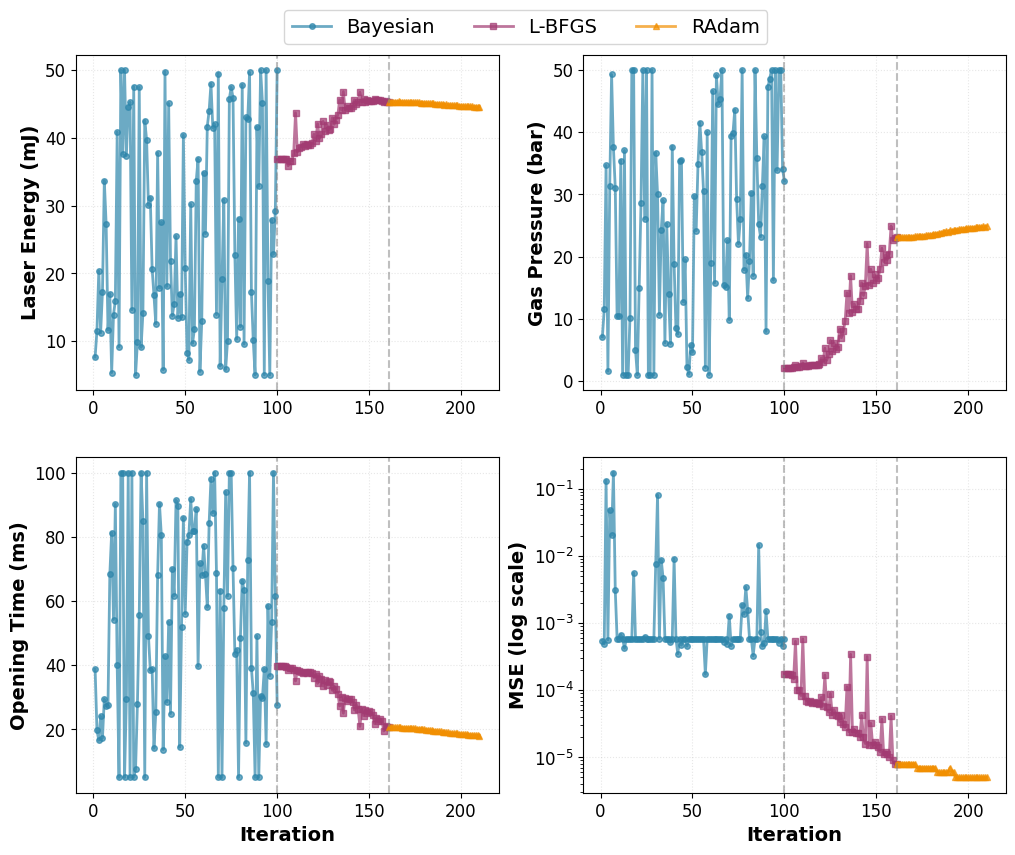

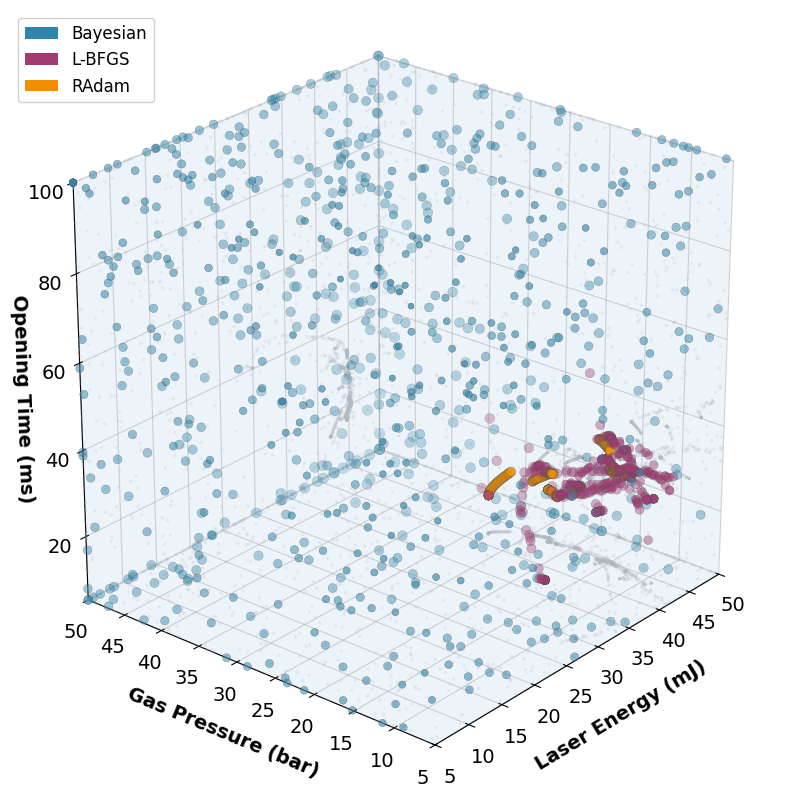

In [4]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import glob
import os

# =============================================================================
# Configuration
# =============================================================================
BASE_DIR = 'comparison_20260114_110450'
BEST_APPROACH = 'bayes_lbfgs_adam'
EXAMPLE_SEED = 391

APPROACHES = ['bayesian_only', 'adam_only', 'lbfgs_only', 'bayes_adam', 'bayes_lbfgs', 'adam_lbfgs', 'bayes_adam_lbfgs', 'bayes_lbfgs_adam']
APPROACH_NAMES = {'bayesian_only': 'Bayesian', 'adam_only': 'RAdam', 'lbfgs_only': 'L-BFGS', 'bayes_adam': 'Bayes+RAdam', 'bayes_lbfgs': 'Bayes+L-BFGS', 'adam_lbfgs': 'RAdam+L-BFGS', 'bayes_adam_lbfgs': 'Bayes+RAdam+L-BFGS', 'bayes_lbfgs_adam': 'Bayes+L-BFGS+RAdam'}

def parse_log_new_format(filename):
    bayesian_data = {'step': [], 'laser_energy': [], 'pressure': [], 'acquisition_time': [], 'mse': []}
    lbfgs_data = {'step': [], 'laser_energy': [], 'pressure': [], 'acquisition_time': [], 'mse': []}
    adam_data = {'step': [], 'laser_energy': [], 'pressure': [], 'acquisition_time': [], 'mse': []}
    
    with open(filename, 'r') as f:
        for line in f:
            if 'Bayesian Step' in line:
                match = re.search(r'Bayesian Step (\d+): params=\[([\d.]+),\s*([\d.]+),\s*([\d.]+)\], MSE=([\d.]+)', line)
                if match:
                    bayesian_data['step'].append(int(match.group(1)))
                    bayesian_data['laser_energy'].append(float(match.group(2)))
                    bayesian_data['pressure'].append(float(match.group(3)))
                    bayesian_data['acquisition_time'].append(float(match.group(4)))
                    bayesian_data['mse'].append(float(match.group(5)))
            elif 'LBFGS Step' in line:
                match = re.search(r'LBFGS Step (\d+): params=\[([\d.]+),\s*([\d.]+),\s*([\d.]+)\], MSE=([\d.]+)', line)
                if match:
                    lbfgs_data['step'].append(int(match.group(1)))
                    lbfgs_data['laser_energy'].append(float(match.group(2)))
                    lbfgs_data['pressure'].append(float(match.group(3)))
                    lbfgs_data['acquisition_time'].append(float(match.group(4)))
                    lbfgs_data['mse'].append(float(match.group(5)))
            elif 'Adam Step' in line:
                match = re.search(r'Adam Step (\d+): params=\[([\d.]+),\s*([\d.]+),\s*([\d.]+)\], MSE=([\d.]+)', line)
                if match:
                    adam_data['step'].append(int(match.group(1)))
                    adam_data['laser_energy'].append(float(match.group(2)))
                    adam_data['pressure'].append(float(match.group(3)))
                    adam_data['acquisition_time'].append(float(match.group(4)))
                    adam_data['mse'].append(float(match.group(5)))
    return bayesian_data, lbfgs_data, adam_data

# Load data from best approach
log_file = f'{BASE_DIR}/seed_{EXAMPLE_SEED}/{BEST_APPROACH}/logs/{BEST_APPROACH}_seed_{EXAMPLE_SEED}.log'
bayesian, lbfgs, adam = parse_log_new_format(log_file)
print(f"Loaded from: {log_file}")
print(f"  Bayesian: {len(bayesian['step'])}, LBFGS: {len(lbfgs['step'])}, RAdam: {len(adam['step'])}")

# Calculate step offsets
lbfgs_offset = bayesian['step'][-1] if bayesian['step'] else 0
lbfgs_steps = [s + lbfgs_offset for s in lbfgs['step']] if lbfgs['step'] else []
adam_offset = lbfgs_offset + (lbfgs['step'][-1] if lbfgs['step'] else 0)
adam_steps = [s + adam_offset for s in adam['step']] if adam['step'] else []

colors = {'bayesian': '#2E86AB', 'lbfgs': '#A23B72', 'adam': '#F18F01'}

# Figure: Convergence plots
fig1 = plt.figure(figsize=(12, 9))
gs = GridSpec(2, 2, figure=fig1, hspace=0.2, wspace=0.2, top=0.93)

params_info = [('laser_energy', 'Laser Energy (mJ)'), ('pressure', 'Gas Pressure (bar)'), ('acquisition_time', 'Opening Time (ms)')]
legend_handles = []
legend_labels = []
for idx, (param, ylabel) in enumerate(params_info):
    ax = fig1.add_subplot(gs[idx // 2, idx % 2])
    line_bay, = ax.plot(bayesian['step'], bayesian[param], 'o-', color=colors['bayesian'], linewidth=2, markersize=4, alpha=0.7)
    if idx == 0:
        legend_handles.append(line_bay)
        legend_labels.append('Bayesian')
    if lbfgs['step']:
        line_lbfgs, = ax.plot(lbfgs_steps, lbfgs[param], 's-', color=colors['lbfgs'], linewidth=2, markersize=4, alpha=0.7)
        ax.axvline(x=lbfgs_offset, color='gray', linestyle='--', alpha=0.5)
        if idx == 0:
            legend_handles.append(line_lbfgs)
            legend_labels.append('L-BFGS')
    if adam['step']:
        line_adam, = ax.plot(adam_steps, adam[param], '^-', color=colors['adam'], linewidth=2, markersize=4, alpha=0.7)
        ax.axvline(x=adam_offset, color='gray', linestyle='--', alpha=0.5)
        if idx == 0:
            legend_handles.append(line_adam)
            legend_labels.append('RAdam')
    if idx > 1:
        ax.set_xlabel('Iteration', fontweight='bold', fontsize=14)
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, alpha=0.3, linestyle=':')

ax4 = fig1.add_subplot(gs[1, 1])
ax4.semilogy(bayesian['step'], bayesian['mse'], 'o-', color=colors['bayesian'], linewidth=2, markersize=4, alpha=0.7)
if lbfgs['step']:
    ax4.semilogy(lbfgs_steps, lbfgs['mse'], 's-', color=colors['lbfgs'], linewidth=2, markersize=4, alpha=0.7)
    ax4.axvline(x=lbfgs_offset, color='gray', linestyle='--', alpha=0.5)
if adam['step']:
    ax4.semilogy(adam_steps, adam['mse'], '^-', color=colors['adam'], linewidth=2, markersize=4, alpha=0.7)
    ax4.axvline(x=adam_offset, color='gray', linestyle='--', alpha=0.5)
ax4.set_xlabel('Iteration', fontweight='bold', fontsize=14)
ax4.set_ylabel('MSE (log scale)', fontweight='bold', fontsize=14)
ax4.tick_params(axis='both', labelsize=12)
ax4.grid(True, alpha=0.3, linestyle=':')

fig1.legend(legend_handles, legend_labels, loc='upper center', ncol=3, fontsize=14, bbox_to_anchor=(0.5, 0.98), borderaxespad=0)

plt.savefig('plots/optimization_convergence.png', dpi=300, bbox_inches='tight')
print("Saved: plots/optimization_convergence.png")

# Summary statistics
all_mse_single = bayesian['mse'] + lbfgs['mse'] + adam['mse']
print(f"\nBayesian iterations: {len(bayesian['step'])}")
print(f"L-BFGS iterations: {len(lbfgs['step'])}")
print(f"RAdam iterations: {len(adam['step'])}")
print(f"Best MSE overall: {min(all_mse_single):.6f}")

# =============================================================================
# Load data from ALL seeds for 3D plot (using best approach)
# =============================================================================
def parse_all_seeds_best_approach(base_dir, approach):
    """Parse all seed log files for the best approach and combine data."""
    all_data = {'laser_energy': [], 'pressure': [], 'acquisition_time': [], 'mse': [], 'optimizer': []}
    
    seed_dirs = glob.glob(os.path.join(base_dir, 'seed_*'))
    
    for seed_dir in seed_dirs:
        seed_name = os.path.basename(seed_dir)
        log_file = os.path.join(seed_dir, approach, 'logs', f'{approach}_{seed_name}.log')
        
        if os.path.exists(log_file):
            bay_data, lbfgs_data, adam_data = parse_log_new_format(log_file)
            
            # Track which optimizer produced each point
            for phase_data, opt_name in [(bay_data, 'bayesian'), (lbfgs_data, 'lbfgs'), (adam_data, 'adam')]:
                all_data['laser_energy'].extend(phase_data['laser_energy'])
                all_data['pressure'].extend(phase_data['pressure'])
                all_data['acquisition_time'].extend(phase_data['acquisition_time'])
                all_data['mse'].extend(phase_data['mse'])
                all_data['optimizer'].extend([opt_name] * len(phase_data['mse']))
    
    return all_data

all_seeds_data = parse_all_seeds_best_approach(BASE_DIR, BEST_APPROACH)
print(f"\nLoaded {len(all_seeds_data['mse'])} total points from all seeds ({BEST_APPROACH})")

# =============================================================================
# FIGURE 2: 3D Parameter Space Plot (ALL SEEDS)
# =============================================================================
from mpl_toolkits.mplot3d import Axes3D

fig2 = plt.figure(figsize=(8, 8))
ax5 = fig2.add_subplot(111, projection='3d')
ax5.set_box_aspect([1, 1, 1.0])

all_laser = np.array(all_seeds_data['laser_energy'])
all_pressure = np.array(all_seeds_data['pressure'])
all_acq = np.array(all_seeds_data['acquisition_time'])
all_mse = np.array(all_seeds_data['mse'])
all_optimizer = np.array(all_seeds_data['optimizer'])

# Clip parameter space
laser_min, laser_max = 5, 50
pressure_min, pressure_max = 5, 50
acq_min, acq_max = 5, 100

mask = ((all_laser >= laser_min) & (all_laser <= laser_max) &
        (all_pressure >= pressure_min) & (all_pressure <= pressure_max) &
        (all_acq >= acq_min) & (all_acq <= acq_max))

all_laser = all_laser[mask]
all_pressure = all_pressure[mask]
all_acq = all_acq[mask]
all_mse = all_mse[mask]
all_optimizer = all_optimizer[mask]
print(f"After clipping: {len(all_mse)} points remaining")

# Optimizer colors (same as convergence plot)
optimizer_colors = {
    'bayesian': '#2E86AB',  # Blue
    'lbfgs': '#A23B72',     # Purple/Magenta
    'adam': '#F18F01'       # Orange
}

# Create color array based on optimizer
colors_array = np.zeros((len(all_optimizer), 4))
for i, opt in enumerate(all_optimizer):
    hex_color = optimizer_colors[opt]
    # Convert hex to RGB
    r = int(hex_color[1:3], 16) / 255.0
    g = int(hex_color[3:5], 16) / 255.0
    b = int(hex_color[5:7], 16) / 255.0
    colors_array[i] = [r, g, b, 0.75]

# Perspective-based point sizes
elev_angle, azim_angle = 25, 220
elev_rad, azim_rad = np.radians(elev_angle), np.radians(azim_angle)
cam_x = np.cos(elev_rad) * np.cos(azim_rad)
cam_y = np.cos(elev_rad) * np.sin(azim_rad)
cam_z = np.sin(elev_rad)

laser_norm = (all_laser - laser_min) / (laser_max - laser_min)
pressure_norm = (all_pressure - pressure_min) / (pressure_max - pressure_min)
acq_norm = (all_acq - acq_min) / (acq_max - acq_min)

depth = cam_x * laser_norm + cam_y * pressure_norm + cam_z * acq_norm
depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-10)
sizes = 18 + 40 * (1 - depth_norm)

# Set pane and grid colors
ax5.xaxis.set_pane_color((0.88, 0.92, 0.96, 0.6))
ax5.yaxis.set_pane_color((0.88, 0.92, 0.96, 0.6))
ax5.zaxis.set_pane_color((0.88, 0.92, 0.96, 0.6))
ax5.xaxis._axinfo["grid"]['color'] = (0.6, 0.6, 0.6, 0.4)
ax5.yaxis._axinfo["grid"]['color'] = (0.6, 0.6, 0.6, 0.4)
ax5.zaxis._axinfo["grid"]['color'] = (0.6, 0.6, 0.6, 0.4)

# Plot projections (shadows)
z_floor = np.full_like(all_acq, acq_min)
ax5.scatter(all_laser, all_pressure, z_floor, c='#b0b8c0', s=6, alpha=0.2, marker='o', edgecolors='none')
y_back = np.full_like(all_pressure, pressure_max)
ax5.scatter(all_laser, y_back, all_acq, c='#b0b8c0', s=6, alpha=0.2, marker='o', edgecolors='none')
x_side = np.full_like(all_laser, laser_max)
ax5.scatter(x_side, all_pressure, all_acq, c='#b0b8c0', s=6, alpha=0.2, marker='o', edgecolors='none')

# Main scatter plot
scatter = ax5.scatter(all_laser, all_pressure, all_acq, c=colors_array, s=sizes, edgecolors='#555555', linewidth=0.3)

ax5.set_xlabel('Laser Energy (mJ)', fontsize=14, fontweight='bold', labelpad=10)
ax5.set_ylabel('Gas Pressure (bar)', fontsize=14, fontweight='bold', labelpad=10)
ax5.set_zlabel('Opening Time (ms)', fontsize=14, fontweight='bold', labelpad=5)
ax5.set_xlim(laser_min, laser_max)
ax5.set_ylim(pressure_min, pressure_max)
ax5.set_zlim(acq_min, acq_max)

n_below = np.sum(all_mse < mse_threshold)
n_above = np.sum(all_mse >= mse_threshold)
print(f"Points below threshold ({mse_threshold}): {n_below}")
print(f"Points at/above threshold (white): {n_above}")

ax5.view_init(elev=elev_angle, azim=azim_angle)
ax5.tick_params(axis='both', which='major', labelsize=14)

# Add legend for optimizer colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=optimizer_colors['bayesian'], label='Bayesian'),
    Patch(facecolor=optimizer_colors['lbfgs'], label='L-BFGS'),
    Patch(facecolor=optimizer_colors['adam'], label='RAdam')
]
ax5.legend(handles=legend_elements, loc='upper left', fontsize=12, framealpha=0.9)

plt.tight_layout()
plt.savefig('plots/parameter_space_3d.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none', pad_inches=0.1)
print("Saved: plots/parameter_space_3d.png")

plt.show()


Loading data from all seeds and approaches...
Seeds: [67, 156, 236, 391, 429, 504, 742, 782, 823, 918]

SUMMARY STATISTICS BY APPROACH

Bayesian:
  Seeds: 10, MSE: 0.000208 ± 0.000095 (min: 0.000035)
  Laser: 39.89, Pressure: 11.16, Acq Time: 24.33

Adam:
  Seeds: 10, MSE: 0.000560 ± 0.000339 (min: 0.000007)
  Laser: 22.71, Pressure: 25.06, Acq Time: 54.91

L-BFGS:
  Seeds: 10, MSE: 0.000517 ± 0.000186 (min: 0.000008)
  Laser: 22.06, Pressure: 25.66, Acq Time: 57.46

Bayes+Adam:
  Seeds: 10, MSE: 0.000080 ± 0.000076 (min: 0.000005)
  Laser: 40.17, Pressure: 11.53, Acq Time: 25.32

Bayes+L-BFGS:
  Seeds: 10, MSE: 0.000013 ± 0.000014 (min: 0.000005)
  Laser: 44.32, Pressure: 19.48, Acq Time: 22.85

Adam+L-BFGS:
  Seeds: 10, MSE: 0.000456 ± 0.000173 (min: 0.000006)
  Laser: 21.75, Pressure: 24.92, Acq Time: 55.61

Bayes+Adam+L-BFGS:
  Seeds: 10, MSE: 0.000079 ± 0.000075 (min: 0.000005)
  Laser: 40.18, Pressure: 11.52, Acq Time: 25.35

Bayes+L-BFGS+Adam:
  Seeds: 10, MSE: 0.000007 ± 0.0000

/tmp/ipykernel_218524/2348733268.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot([stats[a]['mses'] for a in APPROACHES if a in stats],



Saved: plots/approach_comparison_boxplot.png
Saved: plots/approach_comparison_bars.png

APPROACH RANKING BY MEAN MSE
1. Bayes+L-BFGS+Adam: 0.000007 ± 0.000003
2. Bayes+L-BFGS: 0.000013 ± 0.000014
3. Bayes+Adam+L-BFGS: 0.000079 ± 0.000075
4. Bayes+Adam: 0.000080 ± 0.000076
5. Bayesian: 0.000208 ± 0.000095
6. Adam+L-BFGS: 0.000456 ± 0.000173
7. L-BFGS: 0.000517 ± 0.000186
8. Adam: 0.000560 ± 0.000339


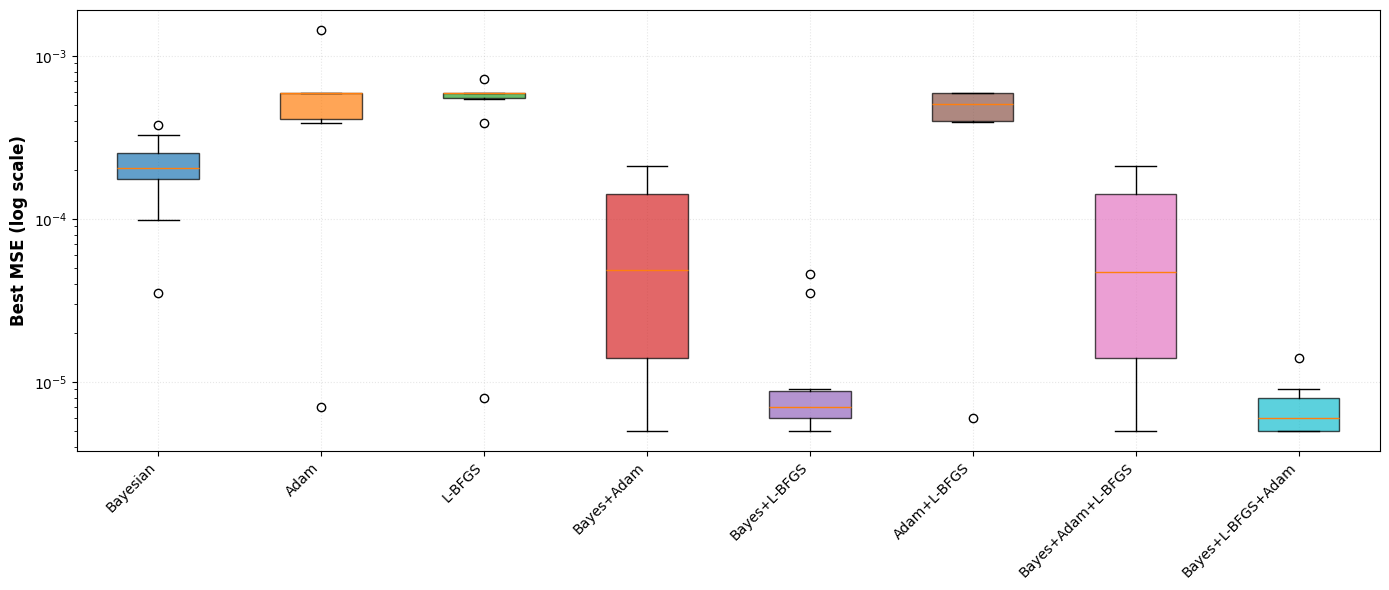

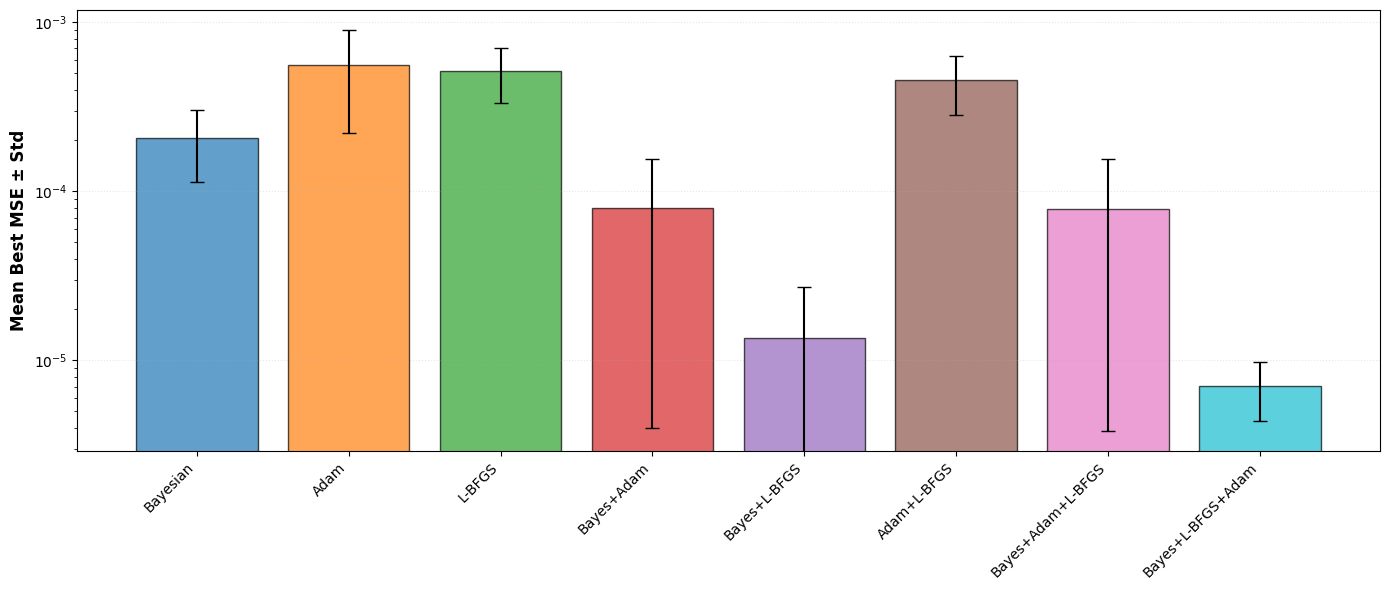

In [2]:
import re, numpy as np, matplotlib.pyplot as plt, glob, os, pandas as pd

BASE_DIR = 'comparison_20260114_110450'
BEST_APPROACH = 'bayes_lbfgs_adam'
APPROACHES = ['bayesian_only', 'adam_only', 'lbfgs_only', 'bayes_adam', 'bayes_lbfgs', 'adam_lbfgs', 'bayes_adam_lbfgs', 'bayes_lbfgs_adam']
APPROACH_NAMES = {'bayesian_only': 'Bayesian', 'adam_only': 'Adam', 'lbfgs_only': 'L-BFGS', 'bayes_adam': 'Bayes+Adam', 'bayes_lbfgs': 'Bayes+L-BFGS', 'adam_lbfgs': 'Adam+L-BFGS', 'bayes_adam_lbfgs': 'Bayes+Adam+L-BFGS', 'bayes_lbfgs_adam': 'Bayes+L-BFGS+Adam'}
APPROACH_COLORS = {'bayesian_only': '#1f77b4', 'adam_only': '#ff7f0e', 'lbfgs_only': '#2ca02c', 'bayes_adam': '#d62728', 'bayes_lbfgs': '#9467bd', 'adam_lbfgs': '#8c564b', 'bayes_adam_lbfgs': '#e377c2', 'bayes_lbfgs_adam': '#17becf'}

def parse_log(fn):
    d = {k: {'step': [], 'laser_energy': [], 'pressure': [], 'acquisition_time': [], 'mse': []} for k in ['bayesian', 'lbfgs', 'adam']}
    with open(fn) as f:
        for line in f:
            for prefix, key in [('Bayesian Step', 'bayesian'), ('LBFGS Step', 'lbfgs'), ('Adam Step', 'adam')]:
                if prefix in line:
                    m = re.search(rf'{prefix} (\d+): params=\[([\d.]+),\s*([\d.]+),\s*([\d.]+)\], MSE=([\d.]+)', line)
                    if m:
                        d[key]['step'].append(int(m.group(1)))
                        d[key]['laser_energy'].append(float(m.group(2)))
                        d[key]['pressure'].append(float(m.group(3)))
                        d[key]['acquisition_time'].append(float(m.group(4)))
                        d[key]['mse'].append(float(m.group(5)))
    return d['bayesian'], d['lbfgs'], d['adam']

def load_all(base, approaches):
    data = {a: {} for a in approaches}
    seeds = []
    for sf in glob.glob(f"{base}/seed_*"):
        sn = os.path.basename(sf)
        snum = int(sn.split('_')[1])
        seeds.append(snum)
        for a in approaches:
            lf = os.path.join(sf, a, 'logs', f'{a}_{sn}.log')
            if os.path.exists(lf):
                b, l, ad = parse_log(lf)
                data[a][snum] = {'bayesian': b, 'lbfgs': l, 'adam': ad}
    return data, sorted(seeds)

def get_best(dd):
    mse, params = [], {k: [] for k in ['laser_energy', 'pressure', 'acquisition_time']}
    for p in ['bayesian', 'lbfgs', 'adam']:
        if dd[p]['mse']:
            mse.extend(dd[p]['mse'])
            for k in params: params[k].extend(dd[p][k])
    if not mse: return None, float('inf')
    idx = np.argmin(mse)
    return {'laser_energy': params['laser_energy'][idx], 'pressure': params['pressure'][idx], 
            'acquisition_time': params['acquisition_time'][idx], 'mse': mse[idx]}, mse[idx]

print("Loading data from all seeds and approaches...")
all_data, seeds = load_all(BASE_DIR, APPROACHES)
print(f"Seeds: {seeds}")

stats = {}
for a in APPROACHES:
    results = [get_best(all_data[a][s])[0] for s in seeds if s in all_data[a] and get_best(all_data[a][s])[0]]
    if results:
        mses = [r['mse'] for r in results]
        stats[a] = {'mses': mses, 'mean': np.mean(mses), 'std': np.std(mses), 'min': np.min(mses), 'n': len(mses),
                    'mean_laser': np.mean([r['laser_energy'] for r in results]),
                    'mean_pressure': np.mean([r['pressure'] for r in results]),
                    'mean_acq': np.mean([r['acquisition_time'] for r in results])}

# Print summary
print("\n" + "="*80)
print("SUMMARY STATISTICS BY APPROACH")
print("="*80)
for a in APPROACHES:
    if a in stats:
        s = stats[a]
        print(f"\n{APPROACH_NAMES[a]}:")
        print(f"  Seeds: {s['n']}, MSE: {s['mean']:.6f} ± {s['std']:.6f} (min: {s['min']:.6f})")
        print(f"  Laser: {s['mean_laser']:.2f}, Pressure: {s['mean_pressure']:.2f}, Acq Time: {s['mean_acq']:.2f}")

# Box plot
fig1, ax1 = plt.subplots(figsize=(14, 6))
bp = ax1.boxplot([stats[a]['mses'] for a in APPROACHES if a in stats], 
                  labels=[APPROACH_NAMES[a] for a in APPROACHES if a in stats], patch_artist=True)
for patch, a in zip(bp['boxes'], [a for a in APPROACHES if a in stats]):
    patch.set_facecolor(APPROACH_COLORS[a])
    patch.set_alpha(0.7)
ax1.set_ylabel('Best MSE (log scale)', fontsize=12, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, linestyle=':')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/approach_comparison_boxplot.png', dpi=300, bbox_inches='tight')
print("\nSaved: plots/approach_comparison_boxplot.png")

# Bar chart
fig2, ax2 = plt.subplots(figsize=(14, 6))
x_pos = np.arange(len([a for a in APPROACHES if a in stats]))
means = [stats[a]['mean'] for a in APPROACHES if a in stats]
stds = [stats[a]['std'] for a in APPROACHES if a in stats]
colors = [APPROACH_COLORS[a] for a in APPROACHES if a in stats]
ax2.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7, capsize=5, edgecolor='black')
ax2.set_ylabel('Mean Best MSE ± Std', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([APPROACH_NAMES[a] for a in APPROACHES if a in stats], rotation=45, ha='right')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, linestyle=':', axis='y')
plt.tight_layout()
plt.savefig('plots/approach_comparison_bars.png', dpi=300, bbox_inches='tight')
print("Saved: plots/approach_comparison_bars.png")

# Ranking
print("\n" + "="*60)
print("APPROACH RANKING BY MEAN MSE")
print("="*60)
for i, (a, s) in enumerate(sorted(stats.items(), key=lambda x: x[1]['mean']), 1):
    print(f"{i}. {APPROACH_NAMES[a]}: {s['mean']:.6f} ± {s['std']:.6f}")

plt.show()


In [3]:
# =============================================================================
# Cell 2: Export statistics and generate LaTeX table
# =============================================================================
import pandas as pd
import numpy as np

# Create comparison DataFrame from stats computed in previous cell
results = []
for a in APPROACHES:
    if a in stats:
        s = stats[a]
        results.append({
            'Approach': APPROACH_NAMES[a],
            'Seeds': s['n'],
            'Mean MSE': s['mean'],
            'Std MSE': s['std'],
            'Min MSE': s['min'],
            'Mean Laser (mJ)': s['mean_laser'],
            'Mean Pressure (bar)': s['mean_pressure'],
            'Mean Opening Time (ms)': s['mean_acq']
        })

df_results = pd.DataFrame(results)

# Sort by Mean MSE
df_results = df_results.sort_values('Mean MSE')

# Save to CSV
df_results.to_csv('plots/approach_comparison.csv', index=False)
print("Saved: plots/approach_comparison.csv")

# Generate LaTeX table with Mean MSE, Std MSE, and mean parameter values
def format_sci(val, prec=2):
    if val == 0: return "0"
    exp = int(np.floor(np.log10(abs(val))))
    mant = val / (10 ** exp)
    return f"{mant:.{prec}f} \\times 10^{{{exp}}}"

latex_lines = [
    r'\begin{table}[htbp]',
    r'\centering',
    r'\caption{Comparison of optimization approaches across 10 random seeds.}',
    r'\label{tab:approach_comparison}',
    r'\begin{tabular}{lccccc}',
    r'\hline',
    r'\textbf{Approach} & \textbf{Mean MSE} & \textbf{Std MSE} & \textbf{Laser (mJ)} & \textbf{Pressure (bar)} & \textbf{Opening Time (ms)} \\',
    r'\hline',
]

for _, row in df_results.iterrows():
    mse_mean = format_sci(row['Mean MSE'])
    mse_std = format_sci(row['Std MSE'])
    laser = f"{row['Mean Laser (mJ)']:.2f}"
    pressure = f"{row['Mean Pressure (bar)']:.2f}"
    opening = f"{row['Mean Opening Time (ms)']:.2f}"
    latex_lines.append(f"{row['Approach']} & ${mse_mean}$ & ${mse_std}$ & {laser} & {pressure} & {opening} \\\\")

latex_lines.extend([r'\hline', r'\end{tabular}', r'\end{table}'])

# Save LaTeX
with open('plots/approach_comparison_table.tex', 'w') as f:
    f.write('\n'.join(latex_lines))
print("Saved: plots/approach_comparison_table.tex")

# Display
print("\n" + "="*80)
print("COMPARISON TABLE (sorted by Mean MSE)")
print("="*80)
print(df_results.to_string(index=False))

print("\n" + "="*80)
print("LaTeX TABLE")
print("="*80)
print('\n'.join(latex_lines))

# Highlight best
best = df_results.iloc[0]
print(f"\n*** BEST APPROACH: {best['Approach']} with Mean MSE = {best['Mean MSE']:.6f} ***")


Saved: plots/approach_comparison.csv
Saved: plots/approach_comparison_table.tex

COMPARISON TABLE (sorted by Mean MSE)
         Approach  Seeds  Mean MSE  Std MSE  Min MSE  Mean Laser (mJ)  Mean Pressure (bar)  Mean Opening Time (ms)
Bayes+L-BFGS+Adam     10  0.000007 0.000003 0.000005        44.752065            19.344105               22.732034
     Bayes+L-BFGS     10  0.000013 0.000014 0.000005        44.315807            19.476274               22.848231
Bayes+Adam+L-BFGS     10  0.000079 0.000075 0.000005        40.178690            11.518574               25.347375
       Bayes+Adam     10  0.000080 0.000076 0.000005        40.165881            11.533668               25.320651
         Bayesian     10  0.000208 0.000095 0.000035        39.892515            11.158251               24.332589
      Adam+L-BFGS     10  0.000456 0.000173 0.000006        21.745041            24.923726               55.607686
           L-BFGS     10  0.000517 0.000186 0.000008        22.061136       